Finetuning Stable-diffusion model




Mounted at /content/drive
Tesla T4, 15360 MiB, 15101 MiB


Saving images (8).jpeg to images (8).jpeg
Saving images (5).jpeg to images (5).jpeg
Saving download (6).jpeg to download (6).jpeg
Saving download (5).jpeg to download (5).jpeg
Saving download (3).jpeg to download (3).jpeg
Saving download (2).jpeg to download (2).jpeg
Saving images (4).jpeg to images (4).jpeg
Saving images (3).jpeg to images (3).jpeg
Saving images (1).jpeg to images (1).jpeg
Saving images.jpeg to images.jpeg
Saving download (1).jpeg to download (1).jpeg
Saving download.jpeg to download.jpeg
Cloning into 'diffusers'...
remote: Enumerating objects: 36685, done.
remote: Total 36685 (delta 0), reused 0 (delta 0), pack-reused 36685
Receiving objects: 100% (36685/36685), 30.27 MiB | 27.22 MiB/s, done.
Resolving deltas: 100% (26035/26035), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

[*] Converted ckpt saved at /content/drive/MyDrive/AI_PICS/models/my_dreambooth_model.safetensors
Dreambooth completed successfully. It took 23.1 minutes.


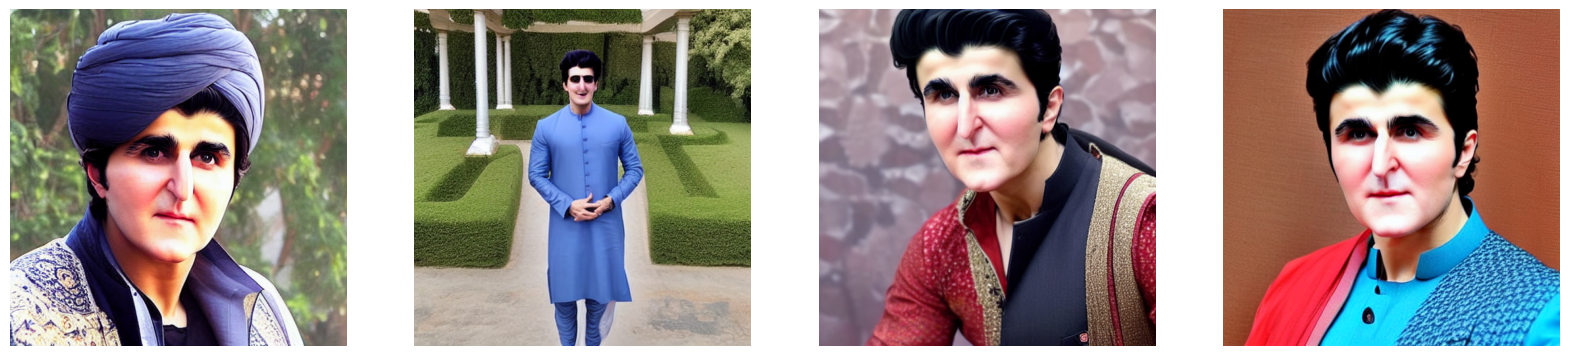

In [1]:
import time

#@title DreamBooth
HUGGINGFACE_TOKEN = ""

#@markdown Name/Path of the initial model. (Find model name [here](https://huggingface.co/models))
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}
BRANCH = "main" #@param {type:"string"}

#@markdown Enter instance prompt and class prompt.\
#@markdown Example 1: photo of zwx person, photo of a person\
#@markdown Example 2: photo of zwx toy, photo of a toy
instance_prompt = "photo of sharukhan" #@param {type:"string"}
class_prompt =  "photo of sharukhan" #@param {type:"string"}
training_steps = 300 #@param {type:"integer"}
learning_rate = 5e-6 #@param {type:"number"}
output_file = "AI_PICS/models/my_dreambooth_model.safetensors" #@param {type:"string"}
#@markdown  Convert to fp16? (takes half the space (2GB)).
fp16 = True #@param {type: "boolean"}

#@markdown Clear log after run?
CLEAR_LOG = False #@param {type:"boolean"}

# Mount google drive for saving the model
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/output"
INSTANCE_DIR = "/content/data/instance"
CLASS_DIR = "/content/data/class"
!mkdir -p $INSTANCE_DIR
!mkdir -p $CLASS_DIR

!rm -rf $OUTPUT_DIR
!mkdir -p $OUTPUT_DIR

if 'pipe' in locals():
  del pipe

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

# Upload training images.
import os
from google.colab import files
import shutil
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

time_start = time.time()
def clear():
    from IPython.display import clear_output; return clear_output()

# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install diffusers
!git clone https://github.com/sagiodev/diffusers.git #https://github.com/huggingface/diffusers.git
%cd diffusers
!git checkout 08b453e3828f80027d881bb460716af95e192bcd -- ./scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install .


# install dreambooth
%cd /content/diffusers/examples/dreambooth
%pip install -r requirements.txt
%pip install bitsandbytes #xformers torch==2.1.0+cu121 # gradio natsort safetensors xformers torch==2.1.0+cu121 accelerate
!accelerate config default


# test bitsandbytes
import bitsandbytes
import torch
print(torch.__version__)

# Dreambooth training - Edit this section to customize parameters
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --revision=$BRANCH \
  --instance_prompt="$instance_prompt" \
  --class_prompt="$class_prompt" \
  --class_data_dir=$CLASS_DIR \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps

#  --enable_xformers_memory_efficient_attention \

########################################
#prompt = "photo of zwx"
prompt = instance_prompt
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

%cd /content/
from diffusers import StableDiffusionPipeline,EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np



if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None




g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    fig=figure(figsize=(5*num_samples,5*num_samples))
    for i in range(num_samples):
        a=fig.add_subplot(1, num_samples,i+1)
        imshow(images[i])
        axis('off')


######################################
# Save to checkpoint file
ckpt_path = '/content/drive/MyDrive/' + output_file
# save model file. Save to a new name if already exist.
dirname= os.path.dirname(ckpt_path)
!mkdir -p $dirname
filename = os.path.basename(ckpt_path)
fileanmeWithoutExt = os.path.splitext(filename)[0]
ExtName = os.path.splitext(filename)[1]
filenamePattern = fileanmeWithoutExt + '%d' + ExtName
i = 1
while os.path.isfile(ckpt_path):
  filename = filenamePattern%i
  ckpt_path = dirname + '/' + filename
  i += 1

half_arg = "--half" if fp16 else ""
!python /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py \
    --use_safetensors \
    --model_path $OUTPUT_DIR \
    --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)

/content


  0%|          | 0/25 [00:00<?, ?it/s]

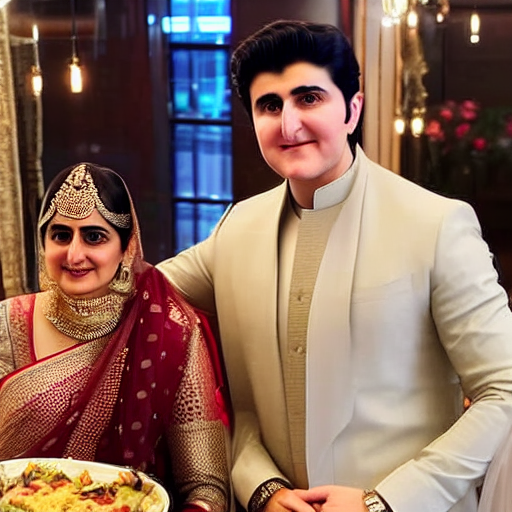

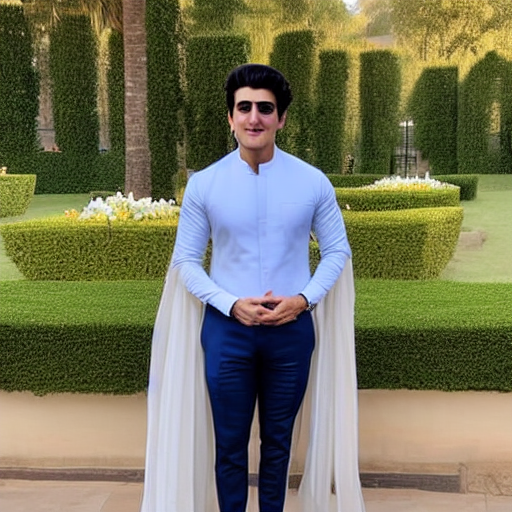

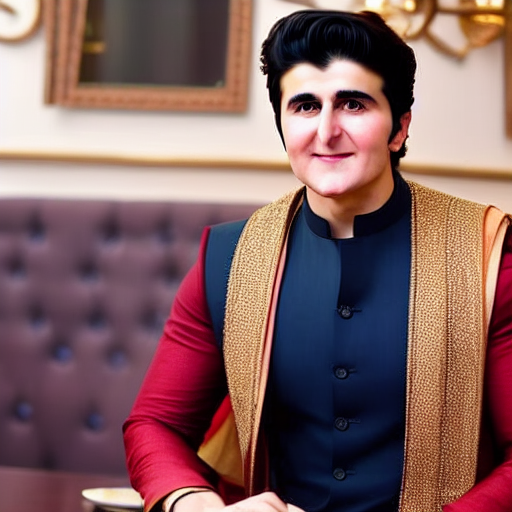

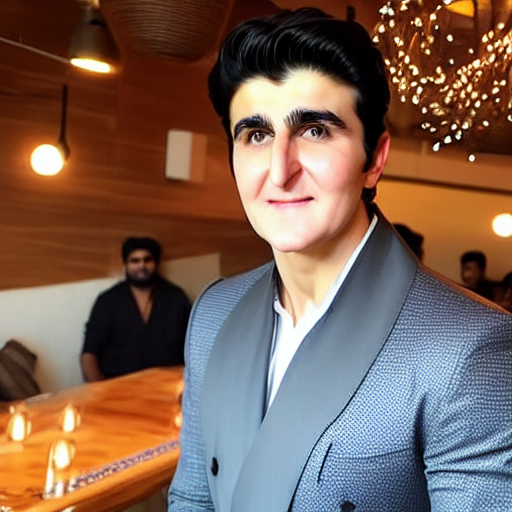

In [2]:
#@title Test image generation from model

prompt = "Photo of sharukhan sitting in a restaurant with side lighting" #@param {type:"string"}
negative_prompt = "disfigured, ugly, bad, immature, cartoon, anime, 3d, painting, b&w" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 25 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = 100 #@param {type:"number"}

%cd /content/
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    from ipywidgets import widgets, HBox
    from IPython.display import display
    for im in images:
        display(im)